# Continuous Reprocessing Mass Balance

SaltProc keeps the core mass constant by having the thorium feed flow add in whatever material is removed such that a constant mass is maintained. This approach works well for batchwise reprocessing.

For continuous reprocessing, the mass can be balanced at the end of each depletion step to have balanced mass, which is a way of adding batchwise reprocessing to continuous reprocessing. If only continuous reprocessing is used, a balanced mass is not achievable without steady state, at least for the test cases and various feed rates for the MSBR. However, in the MSBR, only a partial steady state is achieved by the 6000 day mark, so exact mass balance is not fully achievable within this time frame.
The reason the mass cannot be exactly balanced can be seen below, which shows a simple model with two fission products and a feed. For exact mass balance to exist, the feed would have to continuous be adjusted based on the production and loss of every isotope in the system since they all contribute to the mass. If this is accounted for, it may be possible to generate a feed function over time which enables mass balancing, though this does assume constant flux. Additionally, Serpent2 cannot currently hande feed functions [as mentioned here](http://montecarlo.vtt.fi/mtg/2015_Knoxville/Aarno_Isotalo.pdf).

Serpent2 has 3 different settings for moving materials. Setting 2 functions similarly to setting 1 so will not be discussed here. Their uses are listed below:

- Constant Feed: Type 0.
- Constant Feed: Type 1 using a large source mass.
- Decaying Feed: Type 1 using a medium source mass.

Although Serpent2 cannot handle feed functions, constant and decaying feeds can be implemented by making use of these properties.

## Constant Feed Example

Below is an example of mass balancing using continuous reprocessing.

- Assumes a two element system where each only has a single isotope.
- The isotopes are called $x$ and $y$.
- Both elements are fission products of the feed material being added.
- Both elements are continuously removed while the feed is continuously added.
- Only feed material is present initially.
- The feed has a constant input rate (i.e. type 0 feed or type 1 with a large mass and small reprocessing constant).
- All isotopes are only formed through fission and only leave by reprocessing.




The Bateman equations are as follows:

$$\frac{dN_x}{dt} = \phi \sigma_x \gamma_x N_{feed} - \lambda_{r, x} N_x$$

$$\frac{dN_y}{dt} = \phi \sigma_y \gamma_y N_{feed} - \lambda_{r, y} N_y$$

$$\frac{dN_{feed}}{dt} = \lambda_{feed} - \phi \sigma_x N_{feed} - \phi \sigma_y N_{feed}$$

The solutions are as follows:

$$N_{feed}(t) = e^{-t} + \lambda_{feed} (1 - e^{-t})$$

$$a_n = \phi \sigma_n \gamma_n$$

$$b_n = \lambda_{r, n}$$

$$c_n = \frac{a_n}{1 - b_n} - \lambda_{feed} \left(\frac{a_n}{b_n} + \frac{a_n}{1 - b_n}\right)$$

$$N_{n}(t) = - \frac{a \lambda_{feed} e^{-t}}{b-1} + \frac{a \lambda_{feed}}{b-1} - \frac{a \lambda_{feed}}{(b-1)b} + \frac{a e^{-t}}{b-1} + c  e^{-b t} $$

For a mass balance to be acheived, the sum of all masses, or in this case atoms, needs to remain constant over time. The variable which can be changed is the feed rate.

$$\Sigma_i N_i(t_n) = \Sigma_i N_i(t_m)$$

Since only feed material is present initially:

$$N_{feed} (t=0) = N_{feed} (t) + N_x (t) + N_y (t)$$

If the initial mass is 1:

$$1 = e^{-t} + \lambda_{feed} (1 - e^{-t}) + \Sigma \left[- \frac{a \lambda_{feed} e^{-t}}{b-1} + \frac{a \lambda_{feed}}{b-1} - \frac{a \lambda_{feed}}{(b-1)b} + \frac{a e^{-t}}{b-1} + c  e^{-b t} \right]$$

Solving this equation for $\lambda_{feed}$ would give a constant feed rate as a function of time which would need to be incorporated in order to maintain mass balance in the core.

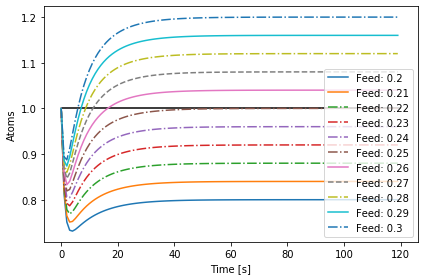

In [1]:
import numpy as np
import matplotlib.pyplot as plt

end_time = 120
gamma_x = 0.2
gamma_y = 0.8
phi = 1
sig_x = 0.5
sig_y = 0.5
lam_x = 0.1
lam_y = 0.2
N_feed_0 = 1
ts = np.arange(0, end_time, 1)
x = phi * sig_x
y = phi * sig_y

# This is the value we can freely change, the feed rate
dx = 0.01
lam_f_s = np.arange(0.2, 0.3+dx, dx)
lines = ["-","--","-.",":"]
for lam_f in lam_f_s:
    sum_list = list()
    line_style = lines[np.random.randint(0, len(lines) - 1)]
    for t in ts:
        N_feed = N_feed_0 * np.exp(-t * (x + y)) + lam_f / (x+y) * (1 - np.exp(-t * (x+y)))
        a = x * gamma_x
        b = lam_x
        c = a / (1-b) - (a/b + a / (1-b)) * lam_f
        N_x = - a * lam_f * np.exp(-t) / (b-1) + a * lam_f / (b-1) - a * lam_f / ((b-1)*b) + (a*np.exp(-t))/(b-1) + c * np.exp(-b * t) 
        a = y * gamma_y
        b = lam_y
        c = a / (1-b) - (a/b + a / (1-b)) * lam_f
        N_y = - a * lam_f * np.exp(-t) / (b-1) + a * lam_f / (b-1) - a * lam_f / ((b-1)*b) + (a*np.exp(-t))/(b-1) + c * np.exp(-b * t) 
        sum_val = N_feed + N_x + N_y
        sum_list.append(sum_val)
    plt.plot(ts, sum_list, line_style, label=f'Feed: {round(lam_f, 3)}')
plt.hlines(N_feed_0, 0, end_time)
plt.ylabel('Atoms')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.show()


It can be seen in this figure that a reprocessing constant of 0.25 for the feed will allow for the mass to be the same as the initial state after enough time. However, for a more complex system, the time taken until the mass reaches this steady state value is likely much longer. This is because in the MSBR, SaltProc runs for ~3000 days before reaching steady state.

## Decreasing Feed Example

This is the other type of feed function currently possible within Serpent2, so it is worth checking whether it is effective for depletion modeling purposes.

Below is an example of mass balancing using continuous reprocessing.

- Assumes a two element system where each only has a single isotope.
- The isotopes are called $x$ and $y$.
- Both elements are fission products of the feed material being added.
- Both elements are continuously removed while the feed is continuously added.
- The feed has a decreasing input rate (i.e. type 1 with a medium mass, causing net feed to decrease over time).
- All isotopes are only formed through fission and only leave by reprocessing.

The Bateman equations are as follows:

$$\frac{dN_x}{dt} = \phi \sigma_x \gamma_x N_{feed} - \lambda_{r, x} N_x$$

$$\frac{dN_y}{dt} = \phi \sigma_y \gamma_y N_{feed} - \lambda_{r, y} N_y$$

$$\frac{dN_{feed}}{dt} = \lambda_{feed} N_{source} - \phi \sigma_x N_{feed} - \phi \sigma_y N_{feed}$$

$$\frac{dN_{source}}{dt} = -\lambda_{feed} N_{source}$$


The solutions are as follows:

$$N_{source}(t) = N_{source, 0} e^{-\lambda_{feed} t}$$

$$x = \phi \sigma_x$$

$$y = \phi \sigma_y$$

$$N_{feed}(t) = N_{feed, 0} e^{-t (x+y)} + \frac{\lambda_{feed} N_{source, 0}}{x + y - \lambda_f} \left( e^{-\lambda_{feed} t} - e^{-t (x+y)} \right)$$

$$a_n = \phi \sigma_n \gamma_n$$

$$b_n = \lambda_{r, n}$$

$$k_n = N_{n, 0} + \frac{a_n N_{feed, 0} (x+y)}{(b_n - x - y)(\lambda_{feed} - x - y)} - \frac{a_n N_{feed, 0} \lambda_{feed}}{(b_n - x - y)(\lambda_{feed} - x - y)}$$

$$N_n(t) = k_n e^{-b t} + \frac{1}{(b_n - x - y)(\lambda_{feed} - x - y)} \left( (a_n N_{feed, 0} \lambda_{feed} - a_n N_{feed, 0} (x+y) + a_n \lambda_{feed} N_{source, 0}) e^{-t(x+y)} - a_n \lambda_{feed}N_{source, 0} e^{-\lambda_{feed} t}   \right)$$


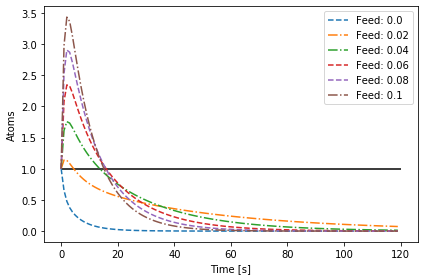

In [10]:
import numpy as np
import matplotlib.pyplot as plt

end_time = 120
gamma_x = 0.2
gamma_y = 0.8
phi = 1
sig_x = 0.5
sig_y = 0.5
lam_x = 0.1
lam_y = 0.2
N_feed_0 = 1
N_x_0 = 0
N_y_0 = 0
N_source_0 = 100
ts = np.arange(0, end_time, 1)
x = phi * sig_x
y = phi * sig_y
h = x+y
c = N_feed_0
g = N_source_0

# This is the value we can freely change, the feed rate
max_val = 0.1
dx = max_val / 5
lam_f_s = np.arange(0, max_val + dx, dx)
lines = ["-","--","-.",":"]
for lam_f in lam_f_s:
    f = lam_f
    sum_list = list()
    line_style = lines[np.random.randint(0, len(lines) - 1)]
    for t in ts:
        N_source = g * np.exp(-f * t)
        N_feed = c * np.exp(-t * h) + f*g/(h-f) * (np.exp(-f*t) - np.exp(-h*t))
        a = x * gamma_x
        b = lam_x
        k = N_x_0 + (a * c * h - a * c * f) / ((b-h) * (f-h))
        N_x = k * np.exp(-b*t) + ((a*c*f - a*c*h + a*f*g)*np.exp(-h*t) - a*f*g*np.exp(-f*t)) / ((b-h)*(f-h))
        a = y * gamma_y
        b = lam_y
        k = N_y_0 + (a * c * h - a * c * f) / ((b-h) * (f-h))
        N_y = k * np.exp(-b*t) + ((a*c*f - a*c*h + a*f*g)*np.exp(-h*t) - a*f*g*np.exp(-f*t)) / ((b-h)*(f-h))
        sum_val = N_feed + N_x + N_y
        sum_list.append(sum_val)
    plt.plot(ts, sum_list, line_style, label=f'Feed: {round(lam_f, 3)}')
plt.hlines(sum_list[0], 0, end_time)
plt.ylabel('Atoms')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.show()


It appears that allowing for the feed rate to decay does not improve the ability to maintain constant mass. However, a constant feed rate and a decaying feed rate are the two options which are possible in Serpent2 continuous reprocessing.
The legend shows the reprocessing constant ($\lambda_{feed}$) term used for the feed, where the feed rate is given as $$\frac{dN_{feed}}{dt} = \lambda_{feed} N_{source}$$
The source is the material which contains all the feed, which decreases over time. This causes the decreasing feed rate.


- Constant: Type 0.
- Constant: Type 1 using a large source mass.
- Decaying: Type 1 using a medium source mass.

Type 2 removal operates similarly to type 1 but only updates the values at each new depletion step. This means step-wise feed is possible, but it would operate as a constant feed over the depletion step. Therefore, this approach would not solve the issue.

# Hybrid Reprocessing Mass Balance

This approach involves continuous reprocessing mixed with batchwise reprocessing. There are a few different ways this can be implemented.

1. Continuous removal with batchwise feeds set to maintain constant mass.

2. Continuous removal and feeds, though feed reprocessing constant adjusted such that constant feed is adjusted after each batch step.

3. Continuous removal and feeds with batch removal/addition to maintain constant mass.

4. Continuous removal of target isotopes while leaving the rest of the system batchwise.

Only 1 and 2 are shown here.

## 1. Batchwise Feed Example

Below is an example of mass balancing using continuous reprocessing and batchwise feed.

- Assumes a two element system where each only has a single isotope.
- The isotopes are called $x$ and $y$.
- Both elements are fission products of the feed material being added.
- Both elements are continuously removed while the feed is continuously added.
- All isotopes are only formed through fission and only leave by reprocessing.

The Bateman equations are as follows:

$$\frac{dN_x}{dt} = \phi \sigma_x \gamma_x N_{feed} - \lambda_{r, x} N_x$$

$$\frac{dN_y}{dt} = \phi \sigma_y \gamma_y N_{feed} - \lambda_{r, y} N_y$$

$$\frac{dN_{feed}}{dt} = -\phi \sigma_x N_{feed} - \phi \sigma_y N_{feed}$$

where after each batchwise reprocessing step,

$$N_{net} = N_{feed} + N_x + N_y$$

by adjusting $N_{feed}$.

The solutions are as follows:

$$x = \phi \sigma_x$$

$$y = \phi \sigma_y$$

$$N_{feed}(t) = N_{feed, 0} e^{-t(x + y)}$$

$$a_n = \phi \sigma_n \gamma_n$$

$$b_n = \lambda_{r, n}$$

$$N_{n}(t) = N_{n, 0} e^{-b_n t} + \frac{a_n N_{feed, 0}}{x+y-b_n} \left( e^{-t(x+y)} - e^{-b_nt} \right) $$

Though for batchwise, the solution becomes

$$N_{feed}(t_{batch}) = initialMass - totalMass$$

for the batchwise step times and

$$N_{feed}(t) = N_{feed, prev} e^{-dt(x + y)}$$

$$N_{n}(t) = N_{n, prev} e^{-b_n dt} + \frac{a_n N_{feed, prev}}{x+y-b_n} \left( e^{-dt(x+y)} - e^{-b_ndt} \right) $$

for the non-batchwise steps, where the $N_{n, prev}$ term comes from the most recent values and $dt$ is the time step.



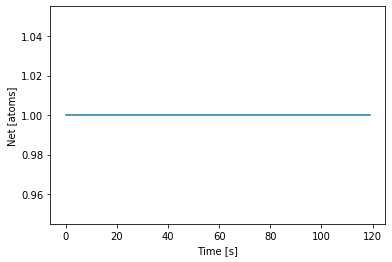

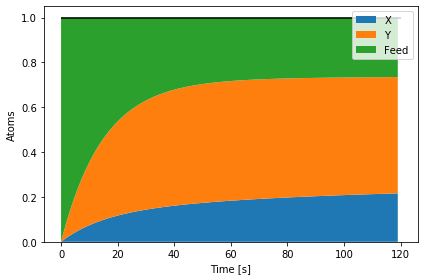

In [1]:
import numpy as np
import matplotlib.pyplot as plt

end_time = 120
gamma_x = 0.2
gamma_y = 0.8
phi = 1
sig_x = 0.05
sig_y = 0.05
lam_x = 0.01
lam_y = 0.02
N_feed_0 = 1
N_x_0 = 0
N_y_0 = 0
ts = np.arange(0, end_time, 1)
depletion_steps = 1 # every X time steps
x = phi * sig_x
y = phi * sig_y

# This is the value we can freely change, the feed rate
dx = 0.01
lines = ["-","--","-.",":"]
sum_list = list()
line_style = lines[np.random.randint(0, len(lines) - 1)]
X_vals = list()
Y_vals = list()
feed_vals = list()
dep_count = 0
feed_c_val = N_feed_0
x_c = N_x_0
y_c = N_y_0
dt = 0
for t in ts:
    if t != 0:
        dt = t - t_prev
    N_feed = feed_c_val * np.exp(-dt * (x + y))
    a = x * gamma_x
    b = lam_x
    N_n_0 = x_c
    N_x = N_n_0 * np.exp(-dt * (b)) - a * feed_c_val / (x+y-b) * (np.exp(-dt * (x + y)) - np.exp(-dt * (b)))
    a = y * gamma_y
    b = lam_y
    N_n_0 = y_c
    N_y = N_n_0 * np.exp(-dt * (b)) - a * feed_c_val / (x+y-b) * (np.exp(-dt * (x + y)) - np.exp(-dt * (b)))
    sum_val = N_feed + N_x + N_y
    if t == 0:
        init_mass = sum_val
    elif sum_val <= init_mass and dep_count == depletion_steps - 1:
        N_feed += init_mass - sum_val
        dep_count = 0
    else:
        dep_count += 1
    feed_c_val = N_feed
    x_c = N_x
    y_c = N_y
    X_vals.append(N_x)
    Y_vals.append(N_y)
    feed_vals.append(N_feed)
    sum_val = N_feed + N_x + N_y
    sum_list.append(sum_val)
    t_prev = t
plt.plot(ts, sum_list)
plt.xlabel('Time [s]')
plt.ylabel('Net [atoms]')
plt.show()
plt.close()
plt.stackplot(ts, X_vals, Y_vals, feed_vals, labels = ['X', 'Y', 'Feed'])
plt.hlines(init_mass, 0, end_time)
plt.ylabel('Atoms')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Constant Adjustable Feed Example

Below is an example of mass balancing using continuous reprocessing with adjustments every batchwise step.

- Assumes a two element system where each only has a single isotope.
- The isotopes are called $x$ and $y$.
- Both elements are fission products of the feed material being added.
- Both elements are continuously removed while the feed is continuously added.
- The feed has a constant input rate (i.e. type 0 feed or type 1 with a large mass and small reprocessing constant).
- The feed rate is adjusted every batch step to solve an *immediate* discrepancy with the net mass in the system, with a minimum feed rate of 0.
- All isotopes are only formed through fission and only leave by reprocessing.

The Bateman equations are as follows:

$$\frac{dN_x}{dt} = \phi \sigma_x \gamma_x N_{feed} - \lambda_{r, x} N_x$$

$$\frac{dN_y}{dt} = \phi \sigma_y \gamma_y N_{feed} - \lambda_{r, y} N_y$$

$$\frac{dN_{feed}}{dt} = \lambda_{feed} - \phi \sigma_x N_{feed} - \phi \sigma_y N_{feed}$$

The solutions are as follows:

$$x = \phi \sigma_x$$

$$y = \phi \sigma_y$$

$$N_{feed}(t) = N_{feed, 0} e^{-t(x+y)} + \frac{\lambda_{feed}}{x+y} (1 - e^{-t(x+y)})$$

$$a_n = \phi \sigma_n \gamma_n$$

$$b_n = \lambda_{r, n}$$

$$N_{n}(t) = N_{n, 0} e^{-b_n t} + \frac{a_n N_{feed, 0}}{x+y-b_n} \left(e^{-b_n t} - e^{-(x+y) t}\right) + \frac{a_n \lambda_{feed}}{(x+y) b_n} \left(1 - e^{-b_n t}\right) + \frac{a_n \lambda_{feed}}{(x+y) (x+y-b_n)} \left(e^{-(x+y) t} - e^{-b_n t}\right) $$

Though for batchwise, the solution becomes

$$\lambda_{feed}(t_{batch}) = \lambda_{feed}(t_{prevBatch}) + \frac{N_{tot}(0) - N_{tot}(t_{batch})}{dt}$$

which sets the feed rate to fix the mass discrepancy in one time step for the batchwise step times and

$$N_{feed}(t) = N_{feed, prev} e^{-dt(x+y)} + \frac{\lambda_{feed}}{x+y} (1 - e^{-dt(x+y)})$$

$$N_{n}(t) = N_{n, prev} e^{-b_n dt} + \frac{a_n N_{feed, prev}}{x+y-b_n} \left(e^{-b_n dt} - e^{-(x+y) dt}\right) + \frac{a_n \lambda_{feed}}{(x+y) b_n} \left(1 - e^{-b_n dt}\right) + \frac{a_n \lambda_{feed}}{(x+y) (x+y-b_n)} \left(e^{-(x+y) dt} - e^{-b_n dt}\right) $$

for the non-batchwise steps, where the $N_{n, prev}$ term comes from the most recent batchwise values and $dt$ is the time step.

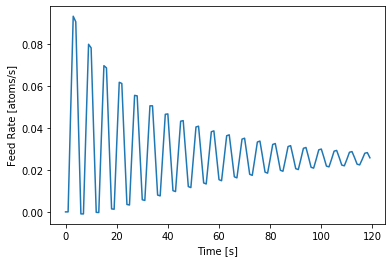

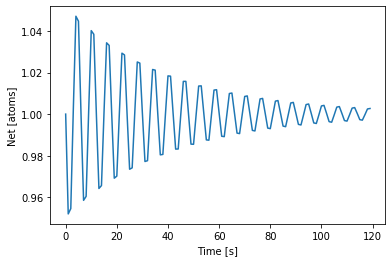

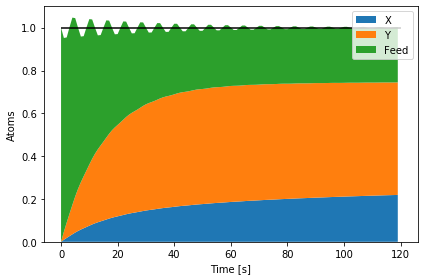

In [2]:
import numpy as np
import matplotlib.pyplot as plt

end_time = 120
gamma_x = 0.2
gamma_y = 0.8
phi = 1
sig_x = 0.05
sig_y = 0.05
lam_x = 0.01
lam_y = 0.02
N_feed_0 = 1
N_x_0 = 0
N_y_0 = 0
lam_f = 0
ts = np.arange(0, end_time, 1)
depletion_steps = 1 # every X time steps
x = phi * sig_x
y = phi * sig_y

# This is the value we can freely change, the feed rate
dx = 0.01
lines = ["-","--","-.",":"]
sum_list = list()
line_style = lines[np.random.randint(0, len(lines) - 1)]
X_vals = list()
Y_vals = list()
feed_vals = list()
dep_count = 0
feed_c_val = N_feed_0
x_c = N_x_0
y_c = N_y_0
feed_rates = list()
dt = 0
for t in ts:
    feed_rates.append(lam_f)
    if t != 0:
        dt = t - t_prev
    N_feed = feed_c_val * np.exp(-dt * (x + y)) + lam_f / (x+y) * (1 - np.exp(-dt * (x+y)))
    a = x * gamma_x
    b = lam_x
    N_n_0 = x_c
    N_x = N_n_0 * np.exp(-b * dt) + a*feed_c_val / (x+y-b) * (np.exp(-b * dt) - np.exp(-dt * (x+y))) + a * lam_f / (b * (x+y)) * (1-np.exp(-b*dt)) + a*lam_f/((x+y)*(x+y-b)) * (np.exp(-dt*(x+y)) - np.exp(-b*dt))
    a = y * gamma_y
    b = lam_y
    N_n_0 = y_c
    N_y = N_n_0 * np.exp(-b * dt) + a*feed_c_val / (x+y-b) * (np.exp(-b * dt) - np.exp(-dt * (x+y))) + a * lam_f / (b * (x+y)) * (1-np.exp(-b*dt)) + a*lam_f/((x+y)*(x+y-b)) * (np.exp(-dt*(x+y)) - np.exp(-b*dt))
    sum_val = N_feed + N_x + N_y
    if t == 0:
        init_mass = sum_val
    elif dep_count == depletion_steps - 1:
        lam_f += (init_mass - sum_val) / (dt * depletion_steps)
        dep_count = 0
    else:
        dep_count += 1
    feed_c_val = N_feed
    x_c = N_x
    y_c = N_y
    X_vals.append(N_x)
    Y_vals.append(N_y)
    feed_vals.append(N_feed)
    sum_val = N_feed + N_x + N_y
    sum_list.append(sum_val)
    t_prev = t
plt.plot(ts, feed_rates)
plt.xlabel('Time [s]')
plt.ylabel('Feed Rate [atoms/s]')
plt.show()
plt.close()
plt.plot(ts, sum_list)
plt.xlabel('Time [s]')
plt.ylabel('Net [atoms]')
plt.show()
plt.close()
plt.stackplot(ts, X_vals, Y_vals, feed_vals, labels = ['X', 'Y', 'Feed'])
plt.hlines(init_mass, 0, end_time)
plt.ylabel('Atoms')
plt.xlabel('Time [s]')
plt.legend()
plt.tight_layout()
plt.show()

## MSBR Continuous Reprocessing Mass Balance

This is a more complex analysis than the previous analytical solutions which makes use of the MSBR design.

Adjustments to the feed rate can be determined by visualization of the net mass.

Adding thorium feed makes the second derivative more negative because there is an immediate decrease in fissionable material, which causes less fission products to be generated. This results in less reprocessing removal to occur. However, the breeding of the thorium eventually causes fission to pick back up.

Adding uranium feed makes the second deritvative more positive because there is an immediate increase in the amount of fissionable material available, which causes an increase in the immediate fission rate. Because the fission products are removed through reprocessing, this causes a net mass decrease. Over time, the buildup of uranium overcomes the removal rate.

Balancing the second derivative changes should allow for a a roughly flat second derivative to be formed.


## SaltProc Steady-State Continuous

This approach starts from the SaltProc data at steady-state and applies the "Cycle Rate" model of continuous removal (see `type_1_flow.ipynb` for more information). Various feed rates are then analyzed to determine the combinations which can minimize the net mass difference from beginning to end.

This model uses the following settings:
- 10 steps over 3000 days
- Uses SaltProc data starting at 3000 days and then simulates continuous reprocessing from that point onwards.

The process to determine adjustments to feed rates is as follows:
- Hold one feed rate constant while adjusting the other
- If final net mass is higher than initial net mass, reduce variable feed rate, and vice versa.
- Once final net mass is same as initial net mass, make adjustment based on second derivative
    - If second derivative is positive, increase Th or decrease U feed.
    - If second derivative is negative, increase U or decrease Th feed.
- Iterated until result is roughly a flat horizontal line.

,Th Feed [kg/day],U Feed [kg/day],Second Derivative
0,2.390,1.915,-
1,2.211,2.000,-
2,2.450,1.890,-
3,0.000,3.530,+
4,13.900,0.000,-
5,1.000,2.740,+
6,5.000,1.150,-
7,7.000,0.820,-
8,2.000,2.108,-
9,1.900,2.160,0


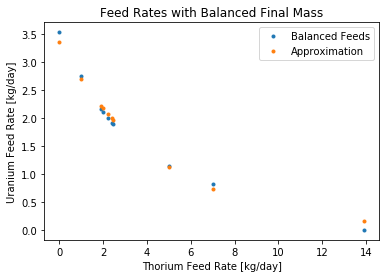

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Th_feed = [2.39, 2.211, 2.45, 0, 13.9, 1, 5, 7, 2, 1.9]
U_feed  = [1.915, 2, 1.89, 3.53, 0, 2.74, 1.15, 0.82, 2.108, 2.16]
secn_d  = ['-', '-', '-', '+', '-', '+', '-', '-', '-', '0']
data_dict = {'Th Feed [kg/day]': Th_feed, 'U Feed [kg/day]': U_feed, 'Second Derivative': secn_d}
plt.plot(Th_feed, U_feed, linestyle='', marker='.', label='Balanced Feeds')
plt.xlabel('Thorium Feed Rate [kg/day]')
plt.ylabel('Uranium Feed Rate [kg/day]')
plt.title('Feed Rates with Balanced Final Mass')
plt.plot(Th_feed, [3.35*np.exp(-0.217*x) for x in Th_feed], linestyle='', marker='.', label='Approximation')
plt.legend()
pd.DataFrame(data=data_dict)


Here are images which show the balanced masses.

This image shows the net mass while using the Thorium feed rate of 2.39 kg/day which is given in Andrei's thesis on SaltProc. The U-233 feed rate was determined by finding when the final mass would be approximately the same as the initial mass, which ends up driving the middle times up (the uranium feed rate is 1.915 kg/day). Flattening the curve would require either decreasing the thorium feed or increasing the uranium feed. However, increasing the uranium feed causes the final mass to be driven up even further while flattening the curve.

A maximum difference of ~200 kg is present, which is a difference of ~0.1\%.

![title](SaltProc_vals.png)

This image shows the net mass using a thorium feed rate of 1 kg/day and a uranium feed rate of 2.74 kg/day. It can be seen here that the large uranium feed compared to the thorium feed caused the second derivative to be positive.

A maximum difference of ~250 kg is present, which is a difference of ~0.2\%.

![title](1_2.74.png)

This image shows the final result which has a ~20 kilograms of mass fluctuations, but is very stable considering the total mass of the system is ~160,000 kilograms. This means the mass fluctuations less than a single percent of the net mass. The thorium feed rate is 1.9 kg/day and the uranium feed rate is 2.16 kg/day.

A maximum difference of ~20 kg is present, which is a difference of ~0.01\%.

![title](Balanced_1.png)

This image shows the mass difference which can occur if feeds are chosen without consideration of mass balancing. For example, using the thorium feed rate provided by SaltProc (2.39 kg/day) and the smallest uranium feed rate to maintain criticality at 6000 days.
This results in a uranium feed rate of 2.12 kg/day.

A maximum difference of ~1000 kg is present, which is a difference of ~0.6\%.

![title](cumulative_keff.png)
![title](net_mass_unbalanced.png)





#### Conclusions

In conclusion, it seems that as long as the feeds are reasonable, then the net mass fluctuations are insignificant and do not need to be accounted for using batch adjustments to the feed rates.